In [50]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(resize=0.3, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(len(faces.target_names))
print(faces.images.shape)

5749
(13233, 38, 38, 3)


In [51]:

faces.images[0]

array([[[0.22745098, 0.19607843, 0.14901961],
        [0.23137255, 0.2       , 0.15294118],
        [0.21176471, 0.18039216, 0.14117648],
        ...,
        [0.14509805, 0.11372549, 0.10196079],
        [0.14117648, 0.10980392, 0.09803922],
        [0.13725491, 0.10588235, 0.09411765]],

       [[0.23921569, 0.20392157, 0.14509805],
        [0.23137255, 0.2       , 0.14509805],
        [0.21176471, 0.18039216, 0.13333334],
        ...,
        [0.14117648, 0.10980392, 0.09803922],
        [0.13725491, 0.10588235, 0.09411765],
        [0.13725491, 0.10588235, 0.09411765]],

       [[0.23529412, 0.20784314, 0.14509805],
        [0.23137255, 0.20392157, 0.14509805],
        [0.21568628, 0.18431373, 0.14117648],
        ...,
        [0.13725491, 0.10588235, 0.09411765],
        [0.13725491, 0.10588235, 0.09411765],
        [0.13725491, 0.10588235, 0.09411765]],

       ...,

       [[0.32156864, 0.3019608 , 0.22352941],
        [0.30588236, 0.29411766, 0.21568628],
        [0.38431373, 0

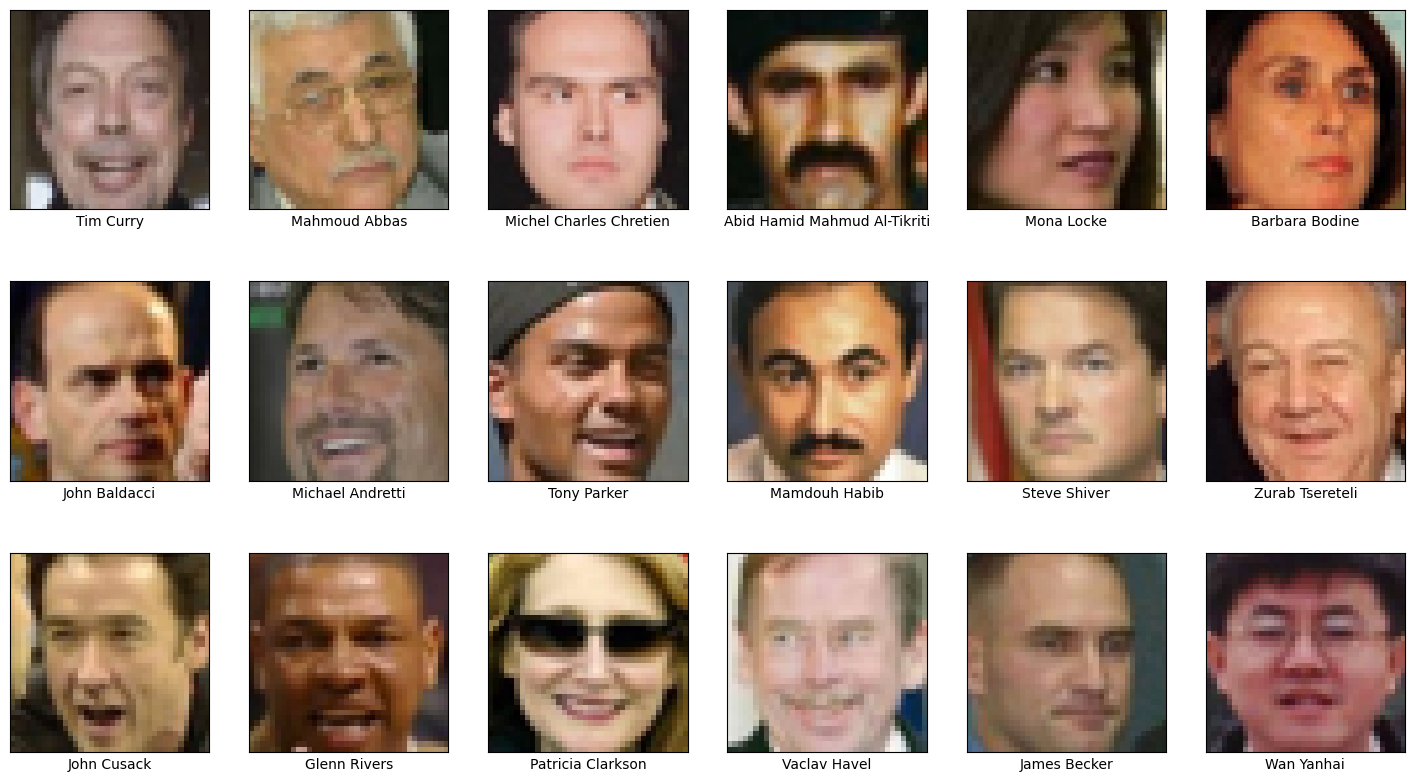

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i]) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [ ]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [3]:
mask = np.zeros(faces.target.shape, dtype=bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(13233, 38, 38, 3)

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


face_images = x_faces  # Normalize pixel values
face_labels = to_categorical(y_faces)


x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, random_state=0)

In [20]:
x_train[0]

array([[[0.21176471, 0.30588236, 0.47058824],
        [0.23529412, 0.30980393, 0.43529412],
        [0.2       , 0.2509804 , 0.32156864],
        ...,
        [0.25882354, 0.24705882, 0.19607843],
        [0.39215687, 0.4       , 0.3764706 ],
        [0.28627452, 0.34117648, 0.32156864]],

       [[0.21960784, 0.30588236, 0.45882353],
        [0.24313726, 0.30588236, 0.42352942],
        [0.18039216, 0.21568628, 0.24705882],
        ...,
        [0.15686275, 0.12941177, 0.05882353],
        [0.23529412, 0.22745098, 0.18039216],
        [0.26666668, 0.3137255 , 0.27450982]],

       [[0.22352941, 0.30588236, 0.44705883],
        [0.23921569, 0.29411766, 0.3882353 ],
        [0.14117648, 0.16470589, 0.16470589],
        ...,
        [0.08235294, 0.05490196, 0.00784314],
        [0.15294118, 0.13333334, 0.09019608],
        [0.28627452, 0.31764707, 0.27450982]],

       ...,

       [[0.25490198, 0.34509805, 0.47058824],
        [0.2509804 , 0.34117648, 0.47843137],
        [0.25882354, 0

In [5]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape =(38, 38, 3), code_size=250):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 38*38*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [6]:
IMG_SHAPE = (38, 38, 3)
encoder, decoder = build_autoencoder(IMG_SHAPE)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 38, 38, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 250)               1083250   
                                                                 
 sequential_1 (Sequential)   (None, 38, 38, 3)         1087332   
                                                                 
Total params: 2,170,582
Trainable params: 2,170,582
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history = autoencoder.fit(x=x_train, y=x_train, epochs=20,
                validation_data=[x_test, x_test])

Epoch 1/20
331/331 [==============================] - 8s 23ms/step - loss: 0.0322 - val_loss: 0.0202
Epoch 2/20
331/331 [==============================] - 6s 19ms/step - loss: 0.0177 - val_loss: 0.0156
Epoch 3/20
331/331 [==============================] - 7s 21ms/step - loss: 0.0140 - val_loss: 0.0128
Epoch 4/20
331/331 [==============================] - 7s 20ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 5/20
331/331 [==============================] - 7s 21ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 6/20
331/331 [==============================] - 6s 19ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 7/20
331/331 [==============================] - 6s 19ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 8/20
331/331 [==============================] - 6s 18ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 9/20
331/331 [==============================] - 6s 18ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 10/20
331/331 [==============================] - 6s 19ms/step - loss: 0.0050 - val_lo

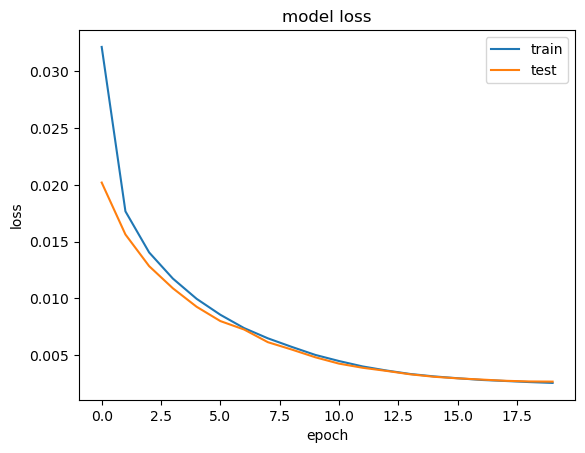

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 119ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


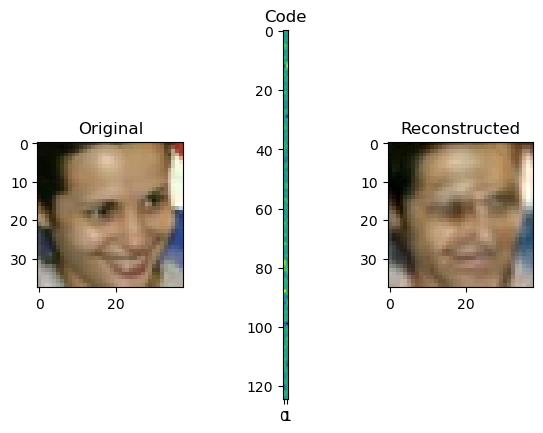

1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


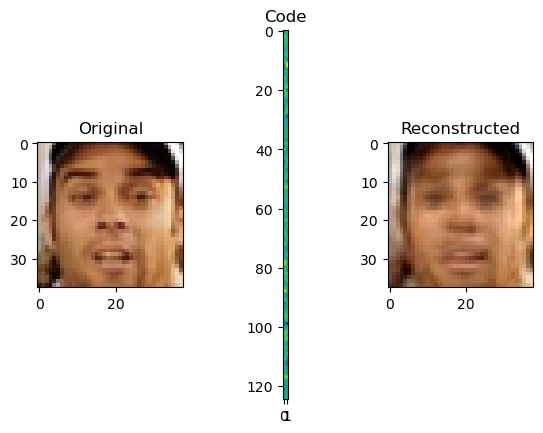

1/1 [==============================] - 0s 41ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


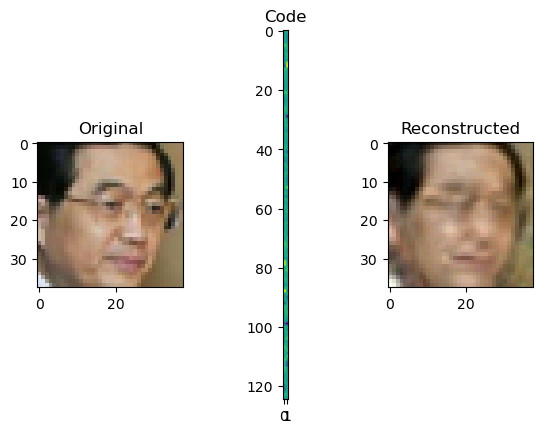

1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


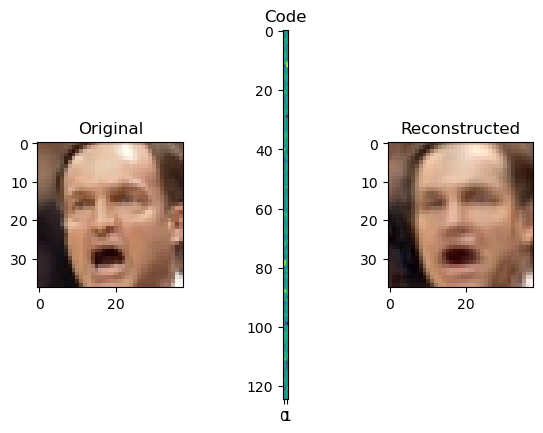

1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


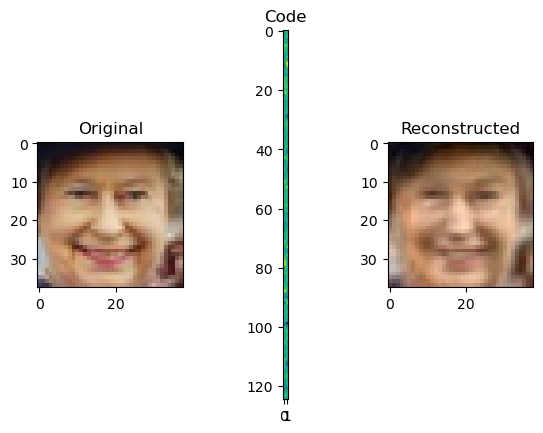

1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


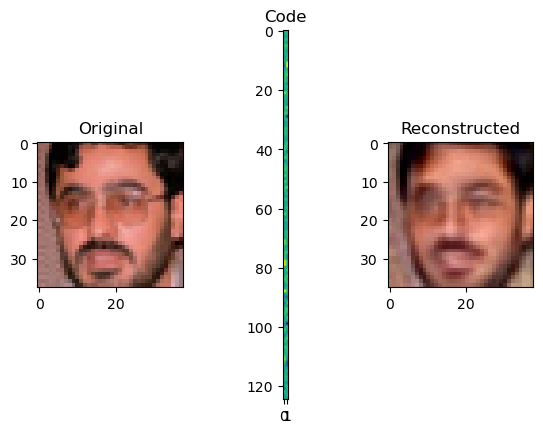

In [9]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco)
    plt.show()

for i in range(5,11,1):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [10]:
def mse(imageA, imageB):

	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [33]:

mse_test = []
for i in range(len(x_test)):
	img = x_test[i]
	code = encoder.predict(img[None])[0]
	reco = decoder.predict(code[None])[0]
	mse_test.append(mse(img, reco))
 
max(mse_test)

1/1 [==============================] - 0s 43ms/step


0.03226268475454593

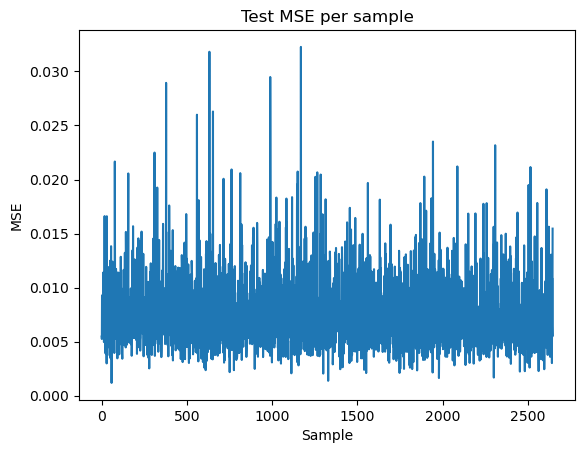

In [34]:
plt.plot(mse_test)
plt.title('Test MSE per sample')
plt.ylabel('MSE')
plt.xlabel('Sample')
plt.show()

In [11]:
mse_one_sample = []
sample_id = 688
img = x_test[sample_id]
code = encoder.predict(img[None])[0]
reco = decoder.predict(code[None])[0]
for i in range(len(x_test)):
	img = x_test[i]
	mse_one_sample.append(mse(img, reco))
 

1/1 [==============================] - 0s 41ms/step


In [12]:
mse_one_sample = np.array(mse_one_sample)
mse_one_sample.argmin()

688

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


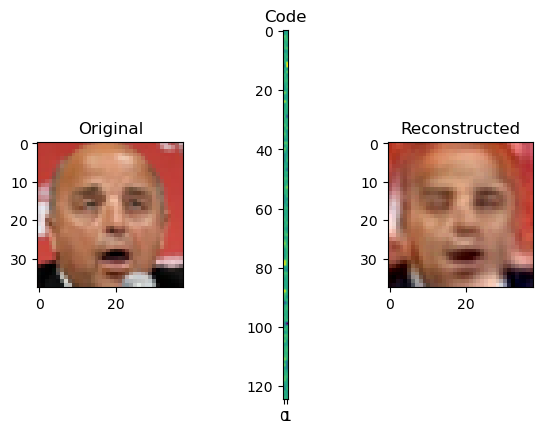

In [13]:
img = x_test[sample_id]
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("Code")
plt.imshow(code.reshape([code.shape[-1]//2,-1]))

plt.subplot(1,3,3)
plt.title("Reconstructed")
plt.imshow(reco)
plt.show()

In [14]:
mse_one_sample = np.array(mse_one_sample)
thrsd = 0.05
if mse_one_sample.min() < thrsd:
    print("actual:{} , prediction: {}".format(faces.target_names[np.array(y_test[sample_id]).argmax()], faces.target_names[np.array(y_test[mse_one_sample.argmin()]).argmax()]))
else:
    print("couldn't recognize that face")

actual:Barry Alvarez , prediction: Barry Alvarez


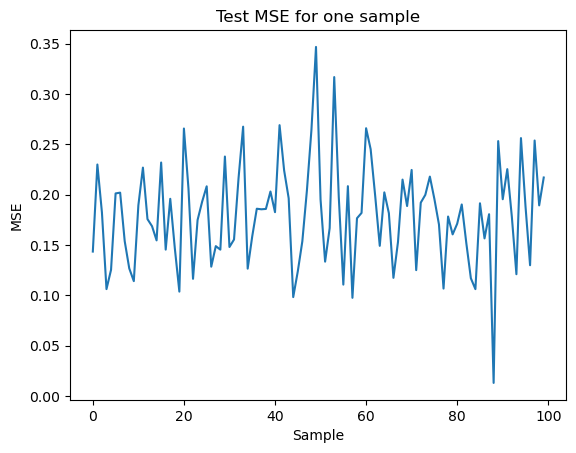

In [15]:
plt.plot(mse_one_sample[600:700])
plt.title('Test MSE for one sample')
plt.ylabel('MSE')
plt.xlabel('Sample')
plt.show()

In [22]:
!pip install tf2onnx --user

In [17]:
import tf2onnx
import onnx
import tensorflow as tf

input_signature = [tf.TensorSpec([None, 38, 38, 3], tf.float32, name='image')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(encoder, input_signature, opset=13)
onnx.save(onnx_model, "encoder.onnx")

output_names = [n.name for n in onnx_model.graph.output]

output_names

['dense']

In [18]:
import tf2onnx
import onnx
import tensorflow as tf

input_signature = [tf.TensorSpec([None, 250], tf.float32, name='code')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(decoder, input_signature, opset=13)
onnx.save(onnx_model, "decoder.onnx")

output_names = [n.name for n in onnx_model.graph.output]

output_names

['reshape']

In [19]:
input_signature = [tf.TensorSpec([None, 38, 38, 3], tf.float32, name='image')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(autoencoder, input_signature, opset=13)
onnx.save(onnx_model, "autoencoder.onnx")

output_names = [n.name for n in onnx_model.graph.output]

output_names

['sequential_1']